# Count Arrays for Sharma et al. 2019

This notebook is a short pipeline that creates a list of count vectors that show the number of reads recorded for each gene at each codon position.

In [1]:
# Let the program know where to find your tools file.
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# Import necessary packages
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from plastid.plotting.plots import *
from scipy import stats
from scipy.stats import kstwo
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr
from tqdm import tqdm
from multiprocess import Pool
import copy
import seaborn as sns

In [88]:
# Define the path to important files
data_path = "/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/human/"
save_path = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts_codon_resolution/human/"
p_site_path = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/p-site_offsets/human/"
gtf_path = "hg38.refGene.gtf"
mutation = 'control'
samp_num = '1'

## Loading up the data files 

In [89]:
# Load in the table of P-site offsets. 
p_offsets=pd.read_csv(p_site_path + mutation + "_RPF_" + samp_num + "_Aligned.toTranscriptome.out_p-site-offsets", 
                      sep="\t")

In [5]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(data_path + gtf_path),return_type=Transcript))

In [90]:
# Read in the alignments from a BAM file and then have it map to the p-site 
alignments = BAMGenomeArray(data_path + mutation + "_RPF_" + samp_num + "_Aligned.sortedByCoord.out.bam")
alignments.set_mapping(kat.VariableThreePrimeMapFactory(p_offsets=p_offsets))

In [91]:
# create a list to hold the vectors
count_vectors = []

# get counts for each transcript
for transcript in transcripts:
    count_vectors.append(transcript.get_counts(alignments))

## Analyzing the data files

In [92]:
#Get the transcript and vector for the gene of interest
my_transcript, my_vector = kat.find_tran_mmus('IGSF8', transcripts, count_vectors)

4998
4999
5000


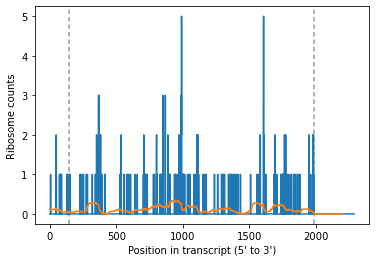

In [93]:
# 30-codon sliding window average
window = np.ones(90).astype(float)/90.0
sliding_window_avg = np.convolve(my_vector,window,mode="valid")


# plot
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(my_vector,label="%s counts" % my_transcript.get_name())
plt.plot(sliding_window_avg,label="30 codon average")
plt.xlabel("Position in transcript (5' to 3')")
plt.ylabel("Ribosome counts")

# add outlines at start & stop codons
plt.axvline(my_transcript.cds_start,color="#999999",dashes=[3,2],zorder=-1)
plt.axvline(my_transcript.cds_end,color="#999999",dashes=[3,2],zorder=-1)

## Alter the count vectors to look at the codons over the cds region.

In [94]:
# Calculate the loacation of the start and end of the coding region for each transcript. 
cds_starts = []
cds_ends = []

for transcript in transcripts:
    cds_starts.append(transcript.cds_start)
    cds_ends.append(transcript.cds_end)

In [95]:
# Create a list of lists containing the counts at each position of the transcript cds regions.
cds_counts_list = []

for i in range(len(count_vectors)):
    x = list(count_vectors[i][cds_starts[i]:cds_ends[i]])
    cds_counts_list.append(x)

In [96]:
# Convert the count lists from nucleotide resolution to codon resolution
codon_counts = []

for i in cds_counts_list:
    codon_counts.append(np.add.reduceat(i, np.arange(0, len(i),3)))

In [97]:
# Convert the unscaled elongation rates to a list so they can be more easily saved
for count, i in zip(codon_counts, list(range(len(codon_counts)))):
    codon_counts[i] = count.tolist()

## Save as a csv

In [98]:
# Create a list that contains all of the gene_ids and transcript_ids of the transcripts
gene_id = []
transcript_id = []

for transcript in transcripts:
    gene_id.append(transcript.attr["gene_name"])
    transcript_id.append(transcript.attr["transcript_id"])

In [99]:
# Insert the gene ids and transcript ids into the codon_count list. 
for i, j in zip(codon_counts, range(len(gene_id))):
    i.insert(0,gene_id[j])
    i.insert(0,transcript_id[j])

In [100]:
# Calculate the longest cds region in our new list of counts
l_tr = kat.find_max_list(codon_counts)

# Define a header that includes labels for the transcript and gene ID as 
# well as numbers that index the cds region position.
header=["transcript_id","gene_id"]+list(range(l_tr))

# insert that header into our counts list. 
codon_counts.insert(0,header)

In [101]:
with open(save_path + mutation + "_" + samp_num + '_counts.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(codon_counts)